In [1]:
from qiskit import IBMQ
import matplotlib.pyplot as plt
IBMQ.load_account()

provider_anl = IBMQ.get_provider(hub='ibm-q-ornl', group='bes-qis', project='argonne')
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support OpenPulse"

In [6]:
#provider.backends()

### Get sampling time

In [125]:
dt = backend_config.dt
print(f"Sampling time: {dt} ns")   
backend_defaults = backend.defaults()
#backend_defaults

Sampling time: 0.2222222222222222 ns


## Get qubit frequency

In [147]:
import numpy as np
qbit = 0

center_est_freq = backend_defaults.qubit_freq_est[qbit]
print(f'Estimated frequency for qbit {qbit} is {center_est_freq}')
freq_span = .02

frequencies = np.linspace(center_est_freq-freq_span/2,
                       center_est_freq+freq_span/2, 
                       50
                      )
frequencies

Estimated frequency for qbit 0 is 4.974286302306341


array([4.9642863 , 4.96469447, 4.96510263, 4.96551079, 4.96591896,
       4.96632712, 4.96673528, 4.96714345, 4.96755161, 4.96795977,
       4.96836793, 4.9687761 , 4.96918426, 4.96959242, 4.97000059,
       4.97040875, 4.97081691, 4.97122508, 4.97163324, 4.9720414 ,
       4.97244957, 4.97285773, 4.97326589, 4.97367406, 4.97408222,
       4.97449038, 4.97489855, 4.97530671, 4.97571487, 4.97612304,
       4.9765312 , 4.97693936, 4.97734753, 4.97775569, 4.97816385,
       4.97857202, 4.97898018, 4.97938834, 4.97979651, 4.98020467,
       4.98061283, 4.981021  , 4.98142916, 4.98183732, 4.98224549,
       4.98265365, 4.98306181, 4.98346998, 4.98387814, 4.9842863 ])

All durations in pulse are given in terms of dt

In [148]:
from qiskit import pulse            
from qiskit.pulse import pulse_lib 
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return (int(num) - (int(num)%16))

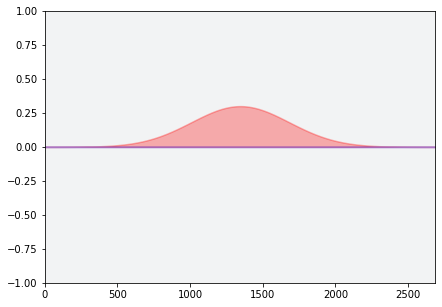

In [149]:
# Drive pulse parameters (us = microsecond)
# This determines the actual width of the gaussians
drive_sigma_ns = 75                     
# This is a truncating parameter
drive_samples_ns = drive_sigma_ns*8        

drive_sigma = get_closest_multiple_of_16(drive_sigma_ns / dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_ns / dt)   # The truncating parameter in units of dt
drive_amp = 0.3
# Drive pulse samples
drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                 sigma=drive_sigma,
                                 amp=drive_amp,
                                 name='freq_sweep_excitation_pulse')
drive_pulse.draw()

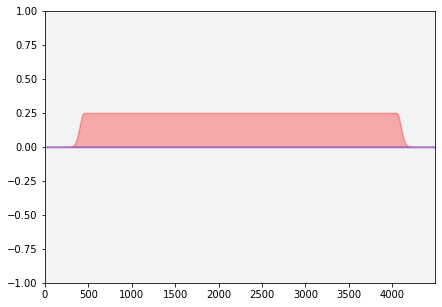

In [180]:
### Construct the measurement pulse
# Measurement pulse parameters

meas_samples_ns = 1000
meas_sigma_ns = 14
# The width of the gaussian part of the rise and fall
meas_risefall_ns = 100    
# and the truncating parameter: how many samples to dedicate to the risefall

meas_samples = get_closest_multiple_of_16(meas_samples_ns / dt)
meas_sigma = get_closest_multiple_of_16(meas_sigma_ns / dt)       # The width of the gaussian part in units of dt
meas_risefall = get_closest_multiple_of_16(meas_risefall_ns / dt) # The truncating parameter in units of dt

meas_amp = 0.25
# Measurement pulse samples
meas_pulse = pulse_lib.gaussian_square(duration=meas_samples,
                                       sigma=meas_sigma,
                                       amp=meas_amp,
                                       risefall=meas_risefall,
                                       name='measurement_pulse')
meas_pulse.draw()

In [181]:
### Construct the acquire pulse to trigger the acquisition
# Acquire pulse samples
acq_cmd = pulse.Acquire(duration=meas_samples)
# Find out which group of qubits need to be acquired with this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qbit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

In [182]:
### Collect the necessary channels
drive_chan = pulse.DriveChannel(qbit)
meas_chan = pulse.MeasureChannel(qbit)
acq_chan = pulse.AcquireChannel(qbit)

In [205]:
# Create the base schedule
# Start with drive pulse acting on the drive channel
schedule = pulse.Schedule(name='Frequency sweep')
schedule += drive_pulse(drive_chan)

# In a new schedule, which we will use again later, add a measurement stimulus on the
# measure channel pulse to trigger readout
measure_schedule = meas_pulse(meas_chan)
# Trigger data acquisition, and store measured values into respective memory slots
measure_schedule += acq_cmd([pulse.AcquireChannel(i) for i 
                             in backend_config.meas_map[meas_map_idx]],
                            [pulse.MemorySlot(i) for i 
                             in backend_config.meas_map[meas_map_idx]])

# shift the start time of the schedule by some duration
schedule += measure_schedule << schedule.duration
schedule += drive_pulse(drive_chan)<< schedule.duration - drive_pulse.duration
schedule += measure_schedule << drive_pulse.duration

# Create the frequency settings for the sweep (MUST BE IN HZ)
schedule_frequencies = [{drive_chan: freq} for freq in frequencies]

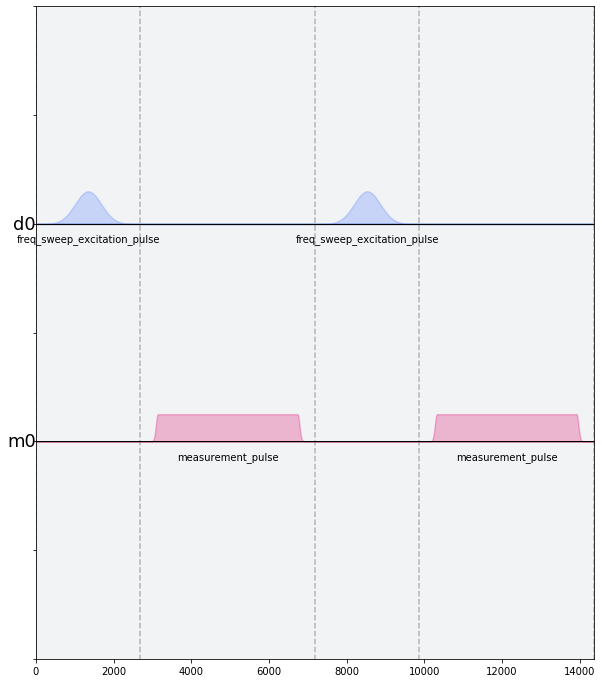

In [206]:
schedule.draw(channels_to_plot=[drive_chan, meas_chan], label=True, scaling=1.0)

In [207]:
from qiskit import assemble

num_shots_per_frequency = 1024
frequency_sweep_program = assemble(schedule,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

In [208]:
job = backend.run(frequency_sweep_program)

In [209]:
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job incurred error      


In [199]:
job.error_message()

'ERROR_RUNNING_JOB'

In [200]:
frequency_sweep_results = job.result(timeout=120) # timeout parameter set to 120 seconds
print(frequency_sweep_results)

JobError: 'Invalid job state. The job should be DONE but it is JobStatus.ERROR'

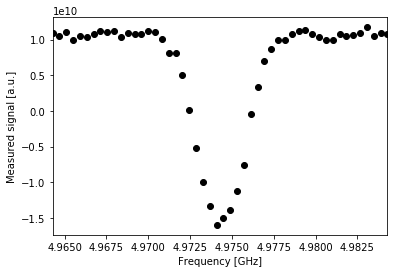

In [160]:
sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qbit])

plt.scatter(frequencies, sweep_values, color='black') # plot real part of sweep values
plt.xlim([min(frequencies), max(frequencies)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

### Fit results

In [161]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [168]:
fit_params, y_fit = fit_function(frequencies,
                                 sweep_values, 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [-2e10, 4.975, 1, 3e10] # initial parameters for curve_fit
                                )
print(fit_params)

[-1.42338245e+08  4.97434495e+00  1.48659252e-03  1.25651437e+10]


/usr/lib/python3.7/site-packages/scipy/optimize/minpack.py:725: ComplexWarning: Casting complex values to real discards the imaginary part
  ydata = ydata.astype(float)


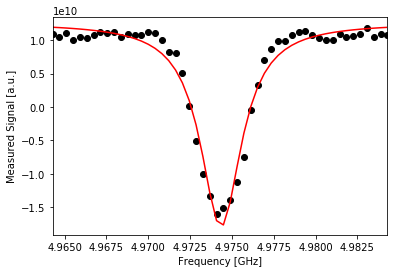

In [163]:
plt.scatter(frequencies, sweep_values, color='black')
plt.plot(frequencies, y_fit, color='red')
plt.xlim([min(frequencies), max(frequencies)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [167]:
print("Fit center:",fit_params[1])
print("IBM center:", center_est_freq)
print("IBM error:", (fit_params[1]-center_est_freq)/fit_params[1])

Fit center: 4.9743449511185425
IBM center: 4.974286302306341
IBM error: 1.179025837125023e-05
